In [1]:
library(igraph)
library(RColorBrewer)
library(rgl)
library(latex2exp)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


This build of rgl does not include OpenGL functions.  Use
 rglwidget() to display results, e.g. via options(rgl.printRglwidget = TRUE).



# The Kuramoto model
By: Marco Chiloiro

### Emergence of spontaneous synchronization

#### Functions

In [2]:
kuramoto=function(steps=M, lambda=0.1, weight=FALSE, h=0.05, final=TRUE, convergence=FALSE, r_conv=NULL, graph, phase, natFreq){
    
    ## Desciption: 
    # Integrates the Kuramoto dynamics. By default, returns the final phases and order parameter.
    
    ## Arguments:
    # steps: number of integration steps
    # lambda: coupling strength
    # weight: T if the graph is weighted
    # h: step size
    # final: if T (default), the function returns only the final results, otherwise returns the results for 
    #        each integration step
    # convergence: if T, the function returns the necessary number of steps to reach the convergence (r_conv must
    #              be assigned in this case)
    # r_conv: reference value for convergence
    # graph: graph of the considered complex network
    # phase: initial phases
    # natFreq: natural frequencies
    
    N=vcount(graph)
    
    if(weight==TRUE){
      adjMat=get.adjacency(graph,sparse = FALSE,attr = "weight")
    }else{
      adjMat=get.adjacency(graph,sparse = FALSE)
    }
  
    adjMat=lambda*adjMat## construct the effective adjMat
    diag(adjMat)<- 0 ## not couple with itself
    
    new_phase <- numeric(N)
    
    if(!final){
        order_parameter <- numeric(steps)
        sins <- matrix(0, nrow=steps, ncol=N)
    }
    
    for(j in 1:steps){
        for(i in 1:N){
            # Runge-Kutta-4
            K_1 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i]))
            K_2 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i] + K_1 * h / 2))
            K_3 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i] + K_2 * h / 2))
            K_4 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i] + K_3 * h))
            tmp <- phase[i] + h*((K_1 + 2*K_2 + 2*K_3 + K_4)/6)

            new_phase[i] <- tmp
        }
        
        phase <- new_phase
        
        if(!final){
            sins[j,] <- sin(phase)
            complex_phase = complex(imaginary = phase)
            order_parameter[j] = Mod(mean(exp(complex_phase)))
        }

        if(convergence){
            complex_phase <- complex(imaginary = phase)
            order_parameter <- Mod(mean(exp(complex_phase)))
            if(Mod(order_parameter-r_conv)<=0.0001){
                return(j)
            }
        }
    }
    
    if (final){
        complex_phase = complex(imaginary = phase)
        order_parameter = Mod(mean(exp(complex_phase)))
        return(list(order_parameter, phase))
    }else{
        return(list(order_parameter, sins))
    }   
}

#### Parameters

In [3]:
set.seed(12)
# number of nodes
N <- 10^2
# size of integration steps
h_step <- 0.05
# number of integration steps
M <- 5*10^2

#### Time test

Time difference of 0.8113079 secs

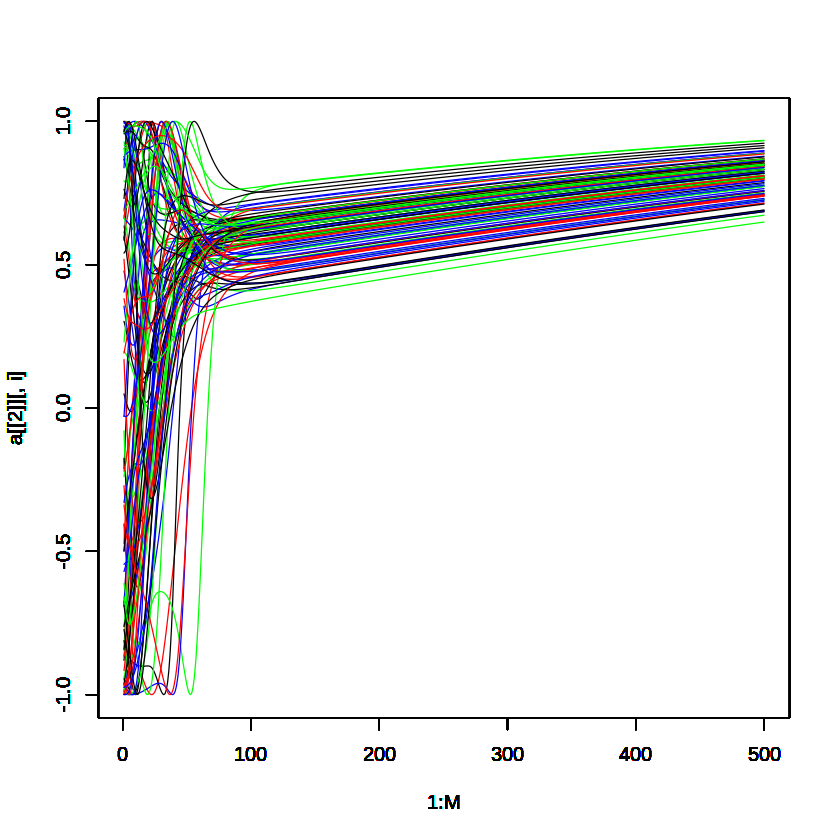

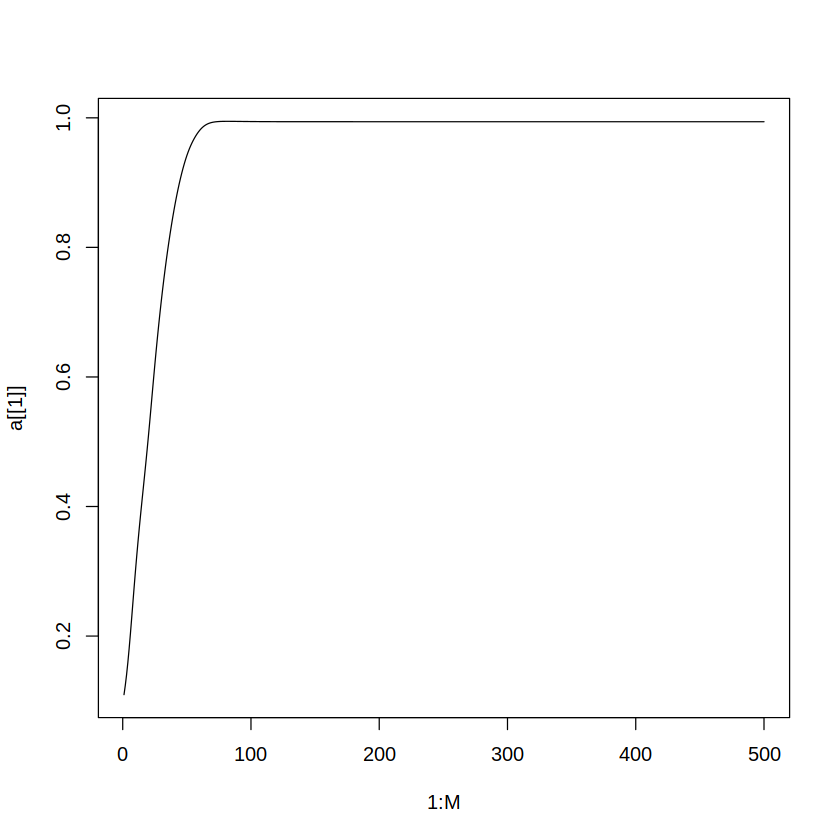

In [4]:
# define a network
m <- 3
g <- barabasi.game(n=N, power=1, m=m, directed=FALSE)
# initial condition
p0 <- runif(N, -pi, pi)
w0 <- runif(N, -1/2, 1/2)
# measure the time execution of kuramoto function 
start_time <- Sys.time()
a <- kuramoto(graph = g, steps=M, lambda=0.7, phase=p0, natFreq=w0, h=h_step, final=F, convergence = F)
end_time <- Sys.time()
end_time - start_time
# plots (final phases Vs number of steps; order parameter Vs number of steps)
colors <- rep(c('red', 'green', 'black', 'blue'),N)
for(i in 1:N){
    plot(1:M, a[[2]][,i], ylim=c(-1,1), type='l', col=colors[i])
    par(new=T)
}
#
par(new=F)
plot(1:M, a[[1]], type = 'l')

#### Study the behaviors of different topologies by computing the order parameter r

In [5]:
# number of iterations along network realizations (NN) and the initial conditions (I).
NN <- 5
I <- 5

#### All-to-all (E(k) ~ N)

[1] 0.006366198

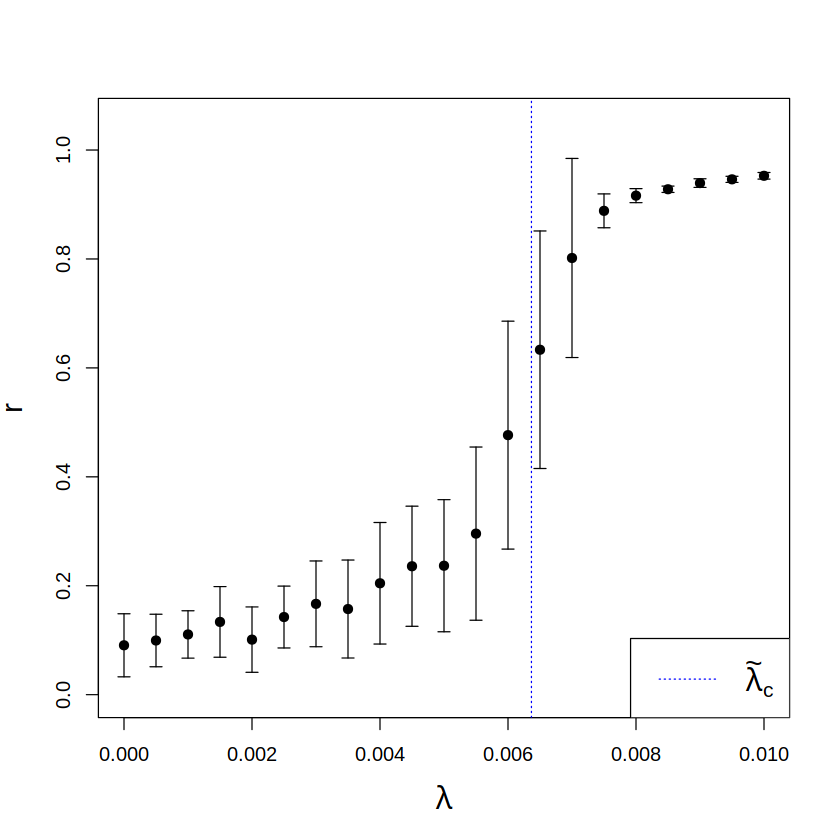

In [6]:
# parameter(s) of the studied graph
p_r <- 1 # wiring prob. (all-to-all)

# sequence of the studied coupling strengths
K_list <- seq(0, 1, 0.05)
lambda_list <- K_list/N
L <- length(K_list)

# initialize results containers
phases <- matrix(0, nrow = L, ncol = N)
coherences <- matrix(0, nrow = L, ncol = I*NN)

# for each considered coupling strength
for (i in 1:L){
    # for each network realization
    for (j in 1:NN){
        # generate the random network
        g <- erdos.renyi.game(n=N, p=p_r, directed=F, loops=F)
        # for each random initial conditions
        for (n in 1:I){
            # initial conditions
            p0 <- runif(N, -pi, pi)
            w0 <- runif(N, -1/2, 1/2)
            # solve the Kuramoto equations
            data <- kuramoto(graph = g, steps=M, lambda = lambda_list[i], phase=p0, natFreq=w0, h=h_step)
            # save results for each iteration 
            coherences[i, n+I*(j-1)] <- data[[1]]
            phases[i,] <- phases[i,] + data[[2]]
            }
        }
    # phase means
    phases[i,] <- phases[i,]/(I*NN)
}
# order parameter mean and std
coherences_mean <- rowMeans(coherences)
coherences_std <- apply(coherences, 1, sd)
# thoretical critical value
Kc <- 2/pi
lambda_c <- Kc/N

lambda_c

# plot
plot(K_list/N, coherences_mean,
    pch=19, xlab=TeX(r'($\lambda$)'), ylab=TeX(r'($r$)'),
    ylim = c(0,max(coherences_mean)+0.1),
    cex.lab = 1.5
)
arrows(K_list/N, coherences_mean-coherences_std, K_list/N, coherences_mean+coherences_std, length=0.05, angle=90, code=3)
legend('bottomright', legend=TeX(r'($\tilde{\lambda}_c)'),
      col='blue', lty=9, cex=1.5)
abline(v=lambda_c, col='blue', lty=9)

#### E-R-G (E(k) = 6)

[1] 0.09111673

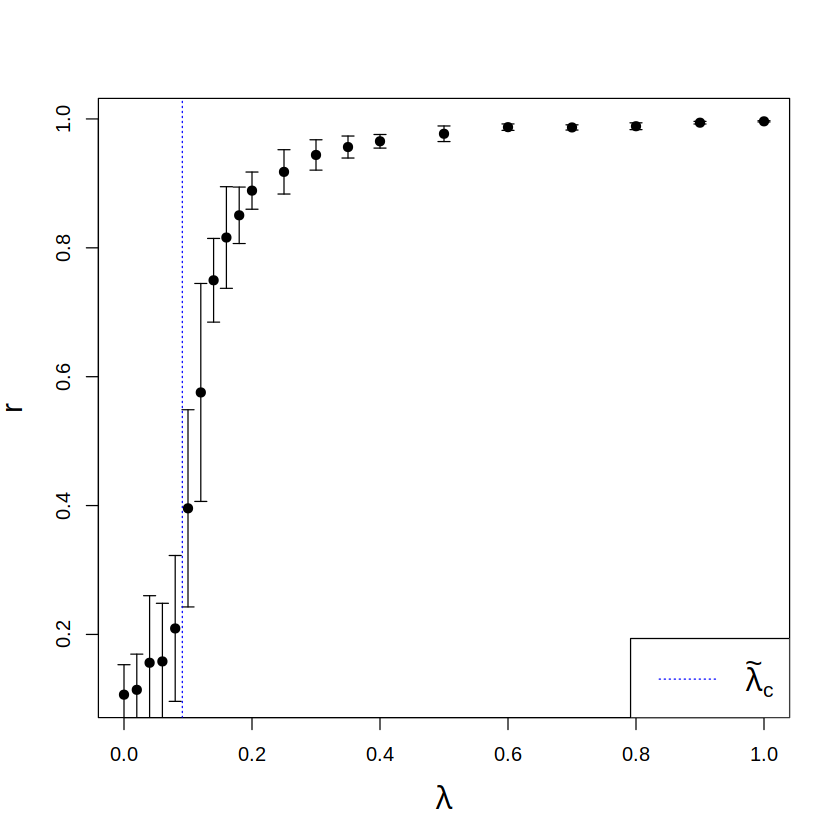

In [7]:
# parameter(s) of the studied graph
p_r <- 6/N # wiring prob. (E(k) = 6 = p(N-1) ~ pN)

lambda_list <- append(seq(0, 0.2, 0.02), append(seq(0.25, 0.4, 0.05), seq(0.5, 1, 0.1)))
L <- length(lambda_list)

phases <- matrix(0, nrow = L, ncol = N)
err_coherences <- numeric(L)
coherences <- matrix(0, nrow = L, ncol = I*NN)

# avereges over degree distribution (to compute the thoretical critical value)
k <- numeric(NN)
k_sqr <- numeric(NN)

for (i in 1:L){
    for (j in 1:NN){
        g <- erdos.renyi.game(n=N, p=p_r, directed=F, loops=F)
        
        # collect the avereges over degree distr.
        k[j] <- mean(degree(g))
        k_sqr[j] <- mean(degree(g)^2)
        
        for (n in 1:I){   
            p0 <- runif(N, -pi, pi)
            w0 <- runif(N, -1/2, 1/2)
            data <- kuramoto(graph = g, steps=M, lambda=lambda_list[i], phase=p0, natFreq=w0, h=h_step)
            coherences[i, n+I*(j-1)] <- data[[1]]
            phases[i,] <- phases[i,] + data[[2]]
            }
        }
    phases[i,] <- phases[i,]/(I*NN)
}

coherences_mean <- rowMeans(coherences)
coherences_std <- apply(coherences, 1, sd)

k_mean <- mean(k)
k_sqr_mean <- mean(k_sqr)
lambda_c <- Kc*k_mean/k_sqr_mean

lambda_c

plot(lambda_list, coherences_mean,
    pch=19, xlab=TeX(r'($\lambda$)'), ylab=TeX(r'($r$)'), cex.lab=1.5
)
arrows(lambda_list, coherences_mean-coherences_std, lambda_list, coherences_mean+coherences_std, length=0.05, angle=90, code=3)
legend('bottomright', legend=TeX(r'($\tilde{\lambda}_c$)'),
       col='blue', lty=9, cex=1.5)
abline(v=lambda_c, col = 'blue', lty=9)

#### WS (E(k) = 6)

[1] 0.1001079

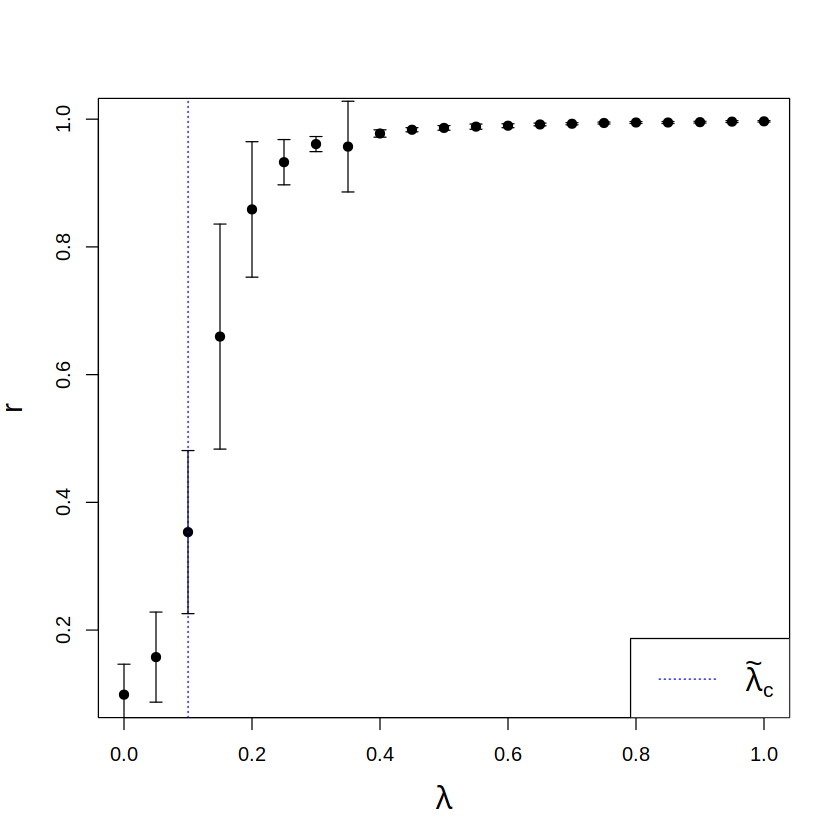

In [8]:
# parameter(s) of the studied graph
p_r <- 0.2 # rewiring prob.
k_ <- 3 # initially connected neighbors per node

lambda_list <- seq(0, 1, 0.05)
L <- length(lambda_list)

phases <- matrix(0, nrow = L, ncol = N)
coherences <- matrix(0, nrow = L, ncol = I*NN)

k <- numeric(NN)
k_sqr <- numeric(NN)

for (i in 1:L){
    for (j in 1:NN){
        g <- sample_smallworld(dim=1, size=N, nei=k_, p=p_r, loops = FALSE, multiple = FALSE)
        k[j] <- mean(degree(g))
        k_sqr[j] <- mean(degree(g)^2)
        for (n in 1:I){   
            p0 <- runif(N, -pi, pi)
            w0 <- runif(N, -1/2, 1/2)
            data <- kuramoto(graph = g, steps=M, lambda=lambda_list[i], phase=p0, natFreq=w0, h=h_step)
            coherences[i, n+I*(j-1)] <- data[[1]]
            phases[i,] <- phases[i,] + data[[2]]
            }
        }
    phases[i,] <- phases[i,]/(I*NN)
}
coherences_mean <- rowMeans(coherences)
coherences_std <- apply(coherences, 1, sd)

k_mean <- mean(k)
k_sqr_mean <- mean(k_sqr)
lambda_c <- Kc*k_mean/k_sqr_mean

lambda_c

plot(lambda_list, coherences_mean,
    pch=19, xlab=TeX(r'($\lambda$)'), ylab=TeX(r'($r$)'), cex.lab=1.5, 
)
arrows(lambda_list, coherences_mean-coherences_std, lambda_list, coherences_mean+coherences_std, length=0.05, angle=90, code=3)
legend('bottomright', legend=TeX(r'($\tilde{\lambda}_c)'),
  col='blue', lty=9, cex=1.5)
abline(v=lambda_c, col = 'blue', lty=9)

#### WS (E(k) = 20)

[1] 0.03132016

Warning message in arrows(lambda_list, coherences_mean - coherences_std, lambda_list, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(lambda_list, coherences_mean - coherences_std, lambda_list, :
“zero-length arrow is of indeterminate angle and so skipped”


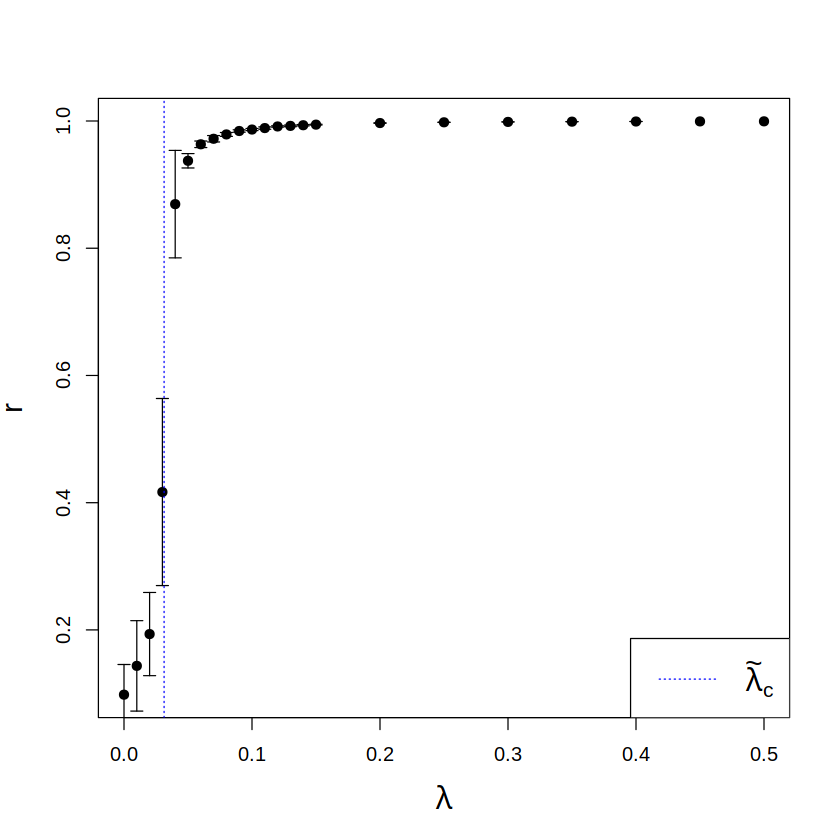

In [9]:
# parameter(s) of the studied graph
p_r <- 0.2 # rewiring prob.
k_ <- 10 # initially connected neighbors per node

lambda_list <- append(seq(0, 0.15, 0.01), seq(0.2, 0.5, 0.05))
L <- length(lambda_list)

phases <- matrix(0, nrow = L, ncol = N)
coherences <- matrix(0, nrow = L, ncol = I*NN)

k <- numeric(NN)
k_sqr <- numeric(NN)

for (i in 1:L){
    for (j in 1:NN){
        g <- sample_smallworld(dim=1, size=N, nei=k_, p=p_r, loops = FALSE, multiple = FALSE)
        k[j] <- mean(degree(g))
        k_sqr[j] <- mean(degree(g)^2)
        for (n in 1:I){   
            p0 <- runif(N, -pi, pi)
            w0 <- runif(N, -1/2, 1/2)
            data <- kuramoto(graph = g, steps=M, lambda=lambda_list[i], phase=p0, natFreq=w0, h=h_step)
            coherences[i, n+I*(j-1)] <- data[[1]]
            phases[i,] <- phases[i,] + data[[2]]
            }
        }
    phases[i,] <- phases[i,]/(I*NN)
}
coherences_mean <- rowMeans(coherences)
coherences_std <- apply(coherences, 1, sd)

k_mean <- mean(k)
k_sqr_mean <- mean(k_sqr)
lambda_c <- Kc*k_mean/k_sqr_mean

lambda_c

plot(lambda_list, coherences_mean,
    pch=19, xlab=TeX(r'($\lambda$)'), ylab=TeX(r'($r$)'), cex.lab=1.5, 
)
arrows(lambda_list, coherences_mean-coherences_std, lambda_list, coherences_mean+coherences_std, length=0.05, angle=90, code=3)
legend('bottomright', legend=TeX(r'($\tilde{\lambda}_c)'),
  col='blue', lty=9, cex=1.5)
abline(v=lambda_c, col = 'blue', lty=9)

#### BA (E(k) = 6)

[1] 0.06719063

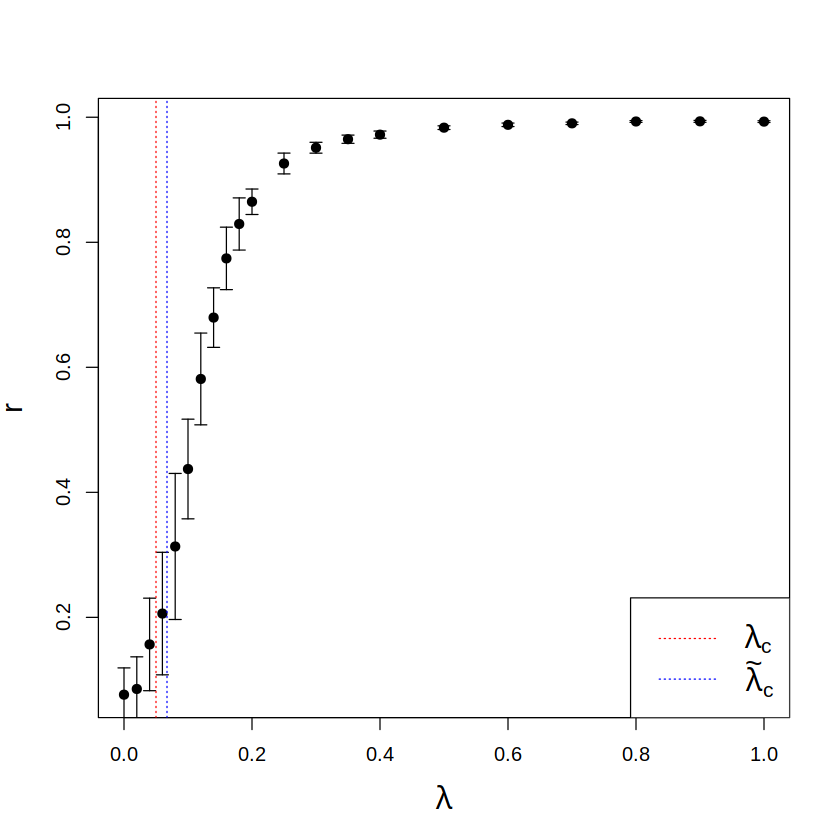

In [10]:
# parameter(s) of the studied graph
m_ <- 3 # edges for each new added node

lambda_list <- append(seq(0, 0.2, 0.02), append(seq(0.25, 0.4, 0.05), seq(0.5, 1, 0.1)))
L <- length(lambda_list)

phases <- matrix(0, nrow = L, ncol = N)
err_coherences <- numeric(L)
coherences <- matrix(0, nrow = L, ncol = I*NN)

k <- numeric(NN)
k_sqr <- numeric(NN)

for (i in 1:L){
    for (j in 1:NN){
        g <- barabasi.game(n=N, power=1, m=m_, directed=FALSE)
        k[j] <- mean(degree(g))
        k_sqr[j] <- mean(degree(g)^2)        
        for (n in 1:I){   
            p0 <- runif(N, -pi, pi)
            w0 <- runif(N, -1/2, 1/2)
            data <- kuramoto(graph = g, steps=M, lambda=lambda_list[i], phase=p0, natFreq=w0, h=h_step)
            coherences[i, n+I*(j-1)] <- data[[1]]
            phases[i,] <- phases[i,] + data[[2]]
            }
        }
    phases[i,] <- phases[i,]/(I*NN)
}

coherences_mean <- rowMeans(coherences)
coherences_std <- apply(coherences, 1, sd)

k_mean <- mean(k)
k_sqr_mean <- mean(k_sqr)
lambda_c <- Kc*k_mean/k_sqr_mean

lambda_c

plot(lambda_list, coherences_mean,
    pch=19, xlab=TeX(r'($\lambda$)'), ylab=TeX(r'($r$)'), cex.lab=1.5  
)
arrows(lambda_list, coherences_mean-coherences_std, lambda_list, coherences_mean+coherences_std, length=0.05, angle=90, code=3)
abline(v=0.05, col = 'red', lty=9)
legend('bottomright', legend=c(TeX(r'($\lambda_c$)'), TeX(r'($\tilde{\lambda}_c$)')),
       col=c('red', 'blue'), lty=9, cex=1.5)
abline(v=lambda_c, col = 'blue', lty=9)

#### BA (E(k) = 20)

[1] 0.02593732

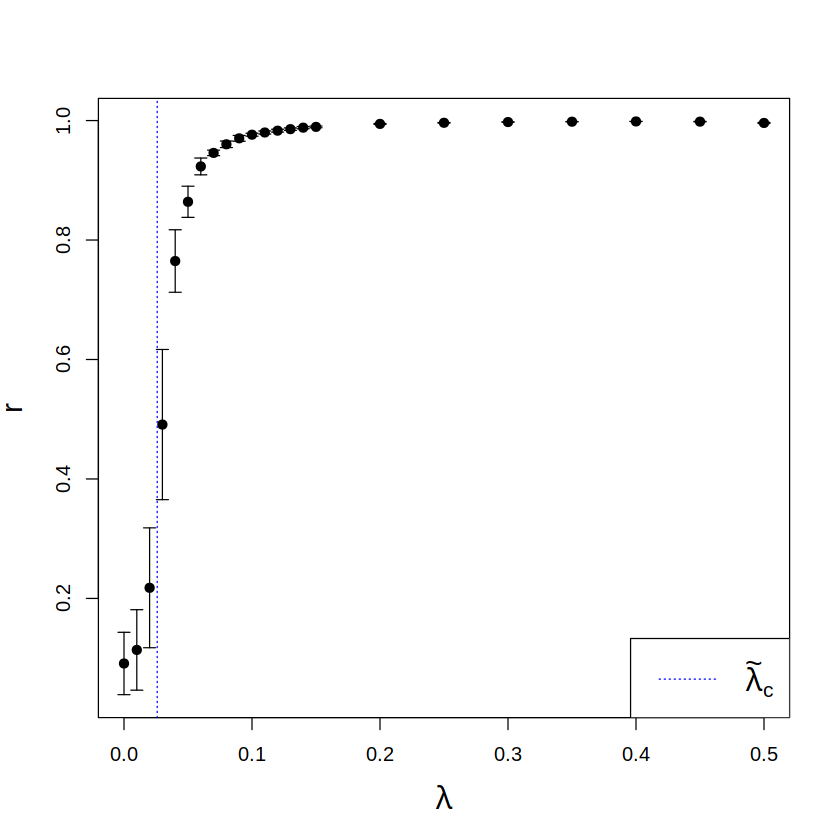

In [11]:
# parameter(s) of the studied graph
m_ <- 10 # edges for each new added node

lambda_list <- append(seq(0, 0.15, 0.01), seq(0.2, 0.5, 0.05))
L <- length(lambda_list)

phases <- matrix(0, nrow = L, ncol = N)
err_coherences <- numeric(L)
coherences <- matrix(0, nrow = L, ncol = I*NN)

k <- numeric(NN)
k_sqr <- numeric(NN)

for (i in 1:L){
    for (j in 1:NN){
        g <- barabasi.game(n=N, power=1, m=m_, directed=FALSE)
        k[j] <- mean(degree(g))
        k_sqr[j] <- mean(degree(g)^2)
        for (n in 1:I){   
            p0 <- runif(N, -pi, pi)
            w0 <- runif(N, -1/2, 1/2)
            data <- kuramoto(graph = g, steps=M, lambda=lambda_list[i], phase=p0, natFreq=w0, h=h_step)
            coherences[i, n+I*(j-1)] <- data[[1]]
            phases[i,] <- phases[i,] + data[[2]]
            }
        }
    phases[i,] <- phases[i,]/(I*NN)
}

coherences_mean <- rowMeans(coherences)
coherences_std <- apply(coherences, 1, sd)

k_mean <- mean(k)
k_sqr_mean <- mean(k_sqr)
lambda_c <- Kc*k_mean/k_sqr_mean

lambda_c

plot(lambda_list, coherences_mean,
    ylim=range(c(coherences_mean-coherences_std, coherences_mean+coherences_std)),
    pch=19, xlab=TeX(r"(\lambda)"), ylab=TeX(r"(r)"), cex.lab = 1.5
)
legend('bottomright', legend = TeX(r'($\tilde{\lambda}_c$)'), col='blue', lty=9, cex=1.5)
arrows(lambda_list, coherences_mean-coherences_std, lambda_list, coherences_mean+coherences_std, length=0.05, angle=90, code=3)
abline(v=Kc*k_mean/k_sqr_mean, col='blue', lty=9)

### Stability of the synchronous state

#### Example of re-synchronization

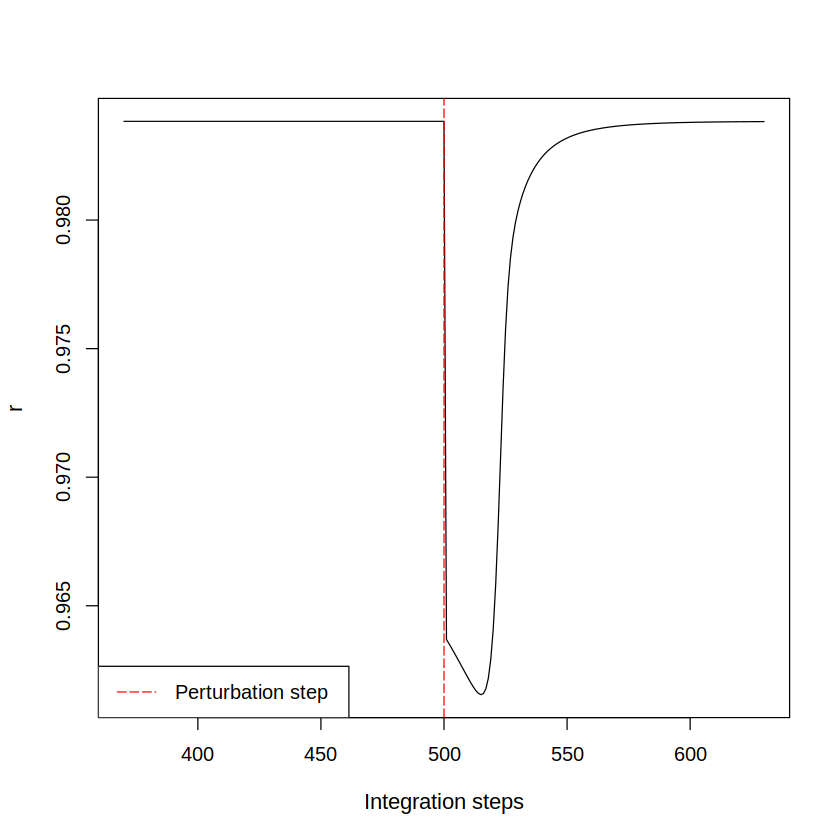

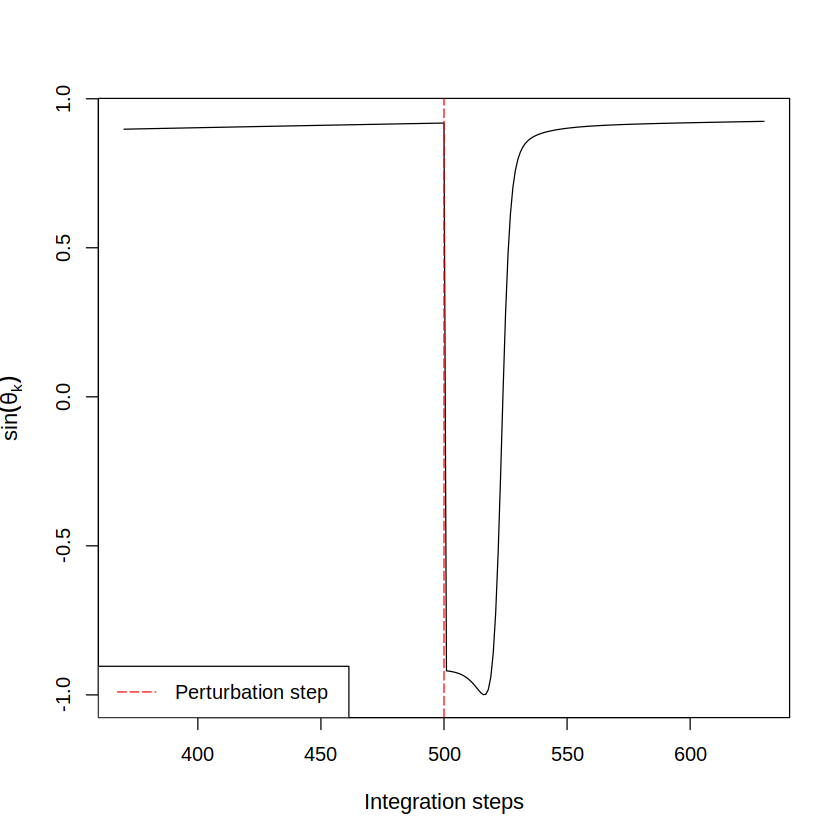

In [13]:
# settings
N <- 10^2 # number of nodes
lam <- 0.6 # coupling stength
g <- barabasi.game(n=N, power=1, m=3, directed=FALSE) # network
p0 <- runif(N, -pi, pi) # initial phases
w0 <- runif(N, -1/2, 1/2) # initial natural frequencies

# compute the synchronized state 
convergence_data <- kuramoto(graph = g, steps=M, lambda=lam, phase=p0, natFreq=w0, h=h_step)
final_r <- convergence_data[[1]]
final_phases <- convergence_data[[2]]

# sin of the final phases (synchronized state)
sins <- kuramoto(graph = g, steps=M, lambda=lam, phase=p0, natFreq=w0, h=h_step, final=F)[[2]]

# vector of the order parameter for each step until convergence
rs <- kuramoto(graph = g, steps=M, lambda=lam, phase=p0, natFreq=w0, h=h_step, final=F)[[1]]

# select a node with degree k
k <- 10 # selected k
degree_list <- degree(g)
indexes <- which(degree_list == k) # indexes of all nodes with degree equals k
chosen_index <- sample(indexes, 1) # sample a index from 'indexes'

# add the perturbation to the corresponding phase
final_phases[chosen_index] <- final_phases[chosen_index] - pi

# take the number of steps to reach again sinchronization 
tau <- kuramoto(graph = g, steps=M, lambda=lam, phase=final_phases, natFreq=w0, h=h_step, convergence=T, r_conv=final_r)

## plots
# re-sinc.
a <- kuramoto(graph = g, steps=tau, lambda=lam, phase=final_phases, natFreq=w0, h=h_step, final=F, convergence=F)
# r Vs # steps
plot((M-tau):(M+tau), append(rs[(M-tau):M],a[[1]]), type = 'l', xlab='Integration steps', ylab='r', cex.lab=1.1)
abline(v=500, col='red', lty=5)
legend('bottomleft', col='red', lty=5, legend='Perturbation step')
# sin(theta) Vs # steps
plot((M-tau):(M+tau), append(sins[,chosen_index][(M-tau):M],a[[2]][,chosen_index]), type='l', xlab='Integration steps', ylab=TeX(r'($\sin (\theta_k)$)'), cex.lab=1.1)
abline(v=500, col='red', lty=5)
legend('bottomleft', col='red', lty=5, legend='Perturbation step')

#### Collect data

In [5]:
# setting
N <- 300
lam <- 0.6
p0 <- runif(N, -pi, pi)
w0 <- runif(N, -1/2, 1/2)
net_real <- 10 # number of network realization
k_max <- 50 # max possible value of k to choose
k_rep <- 20 # number of selected node for each value of k

# initialize vectors to collect the results
tau <- numeric(k_max-2)
tau_err <- numeric(k_max-2)

# for each k in [3, k_max]
for(k in 3:k_max){
    i <- 0
    tau_tmp <- c()
    # for each network realization
    for(j in 1:net_real){
        # generate network
        g <- barabasi.game(n=N, power=1, m=3, directed=FALSE)
        degree_list <- degree(g)
        k_list <- sort(degree_list[!duplicated(degree_list)])

        # Is there at least one node with degree k within the network?
        if(k %in% k_list){
            old_index <- c(0)
            # sync state
            convergence_data <- kuramoto(graph = g, steps=M, lambda=lam, phase=p0, natFreq=w0, h=h_step)
            final_r <- convergence_data[[1]]
            final_phases <- convergence_data[[2]]
            
            indexes <- which(degree_list == k)
            
            # for each chosen node of degree k
            for(j in 1:k_rep){
                # pertuated phases
                pert_phases <- final_phases
                chosen_index <- sample(indexes, 1)
                
                # Was the node already being chosen?
                if(!(chosen_index %in% old_index)){
                    pert_phases[chosen_index] <- final_phases[chosen_index] - pi
                    old_index <- append(old_index,chosen_index)
                    # re-sync
                    i <- i+1
                    tau_tmp[i] <- kuramoto(graph = g, steps=M, lambda=lam, phase=pert_phases, natFreq=w0, h=h_step, convergence=T, r_conv=final_r)
                }
            }
        }
    }
    if(length(tau_tmp)>1){
        tau[k-2] <- mean(tau_tmp)
        tau_err[k-2] <- sd(tau_tmp)
    }
}
tau <- tau[which(tau != 0)]
tau_err <- tau_err[which(tau != 0)]
K <- (3:k_max)[which(tau != 0)]

#### L-S fit: $\langle \tau \rangle = a + bk^{-1}$


Call:
lm(formula = tau ~ k, data = data)

Coefficients:
(Intercept)            k  
      24.96        82.19  


Warning message in arrows(K, (tau - tau_err) * h_step, K, (tau + tau_err) * h_step, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(K, (tau - tau_err) * h_step, K, (tau + tau_err) * h_step, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(K, (tau - tau_err) * h_step, K, (tau + tau_err) * h_step, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in plot.xy(xy, type, ...):
“plot type 'line' will be truncated to first character”


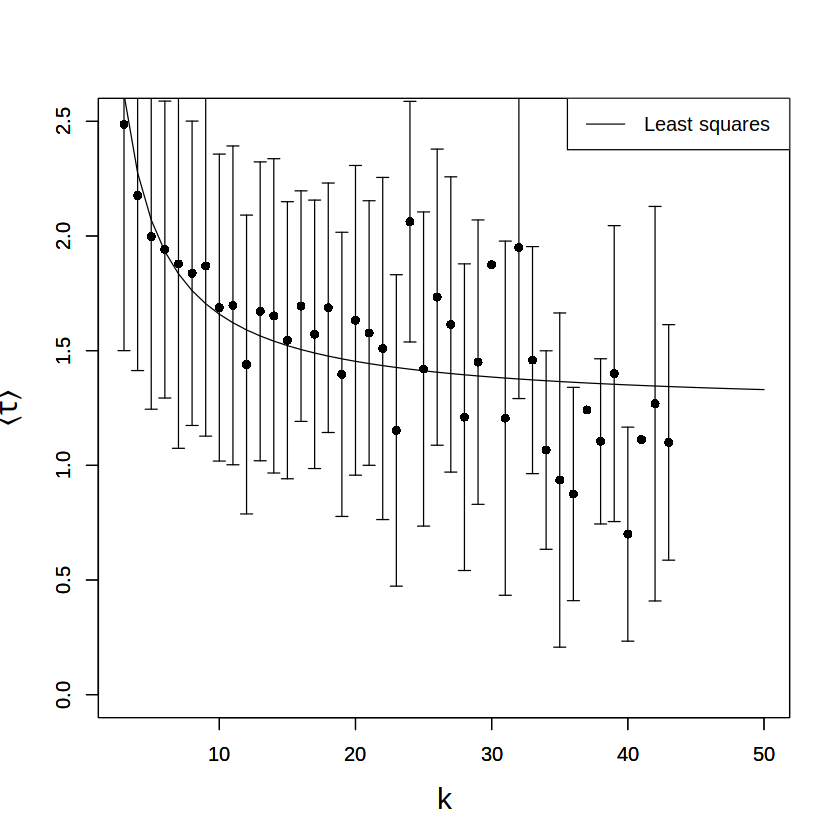

In [7]:
data <- data.frame('k'=1/K,
                  'tau'=tau
                  )

ls <- lm(tau ~ k, data = data)
ls
a <- 24.96
m <- 82.19 
# plot
plot(K[-c(44,45)], tau[-c(44,45)]*h_step, pch=16, xlim=c(3, k_max), ylim=c(0,50)*h_step, xlab='k', ylab=TeX(r'($\langle \tau \rangle$)'), cex.lab=1.5)
arrows(K, (tau-tau_err)*h_step, K, (tau+tau_err)*h_step, length=0.05, angle=90, code=3)
par(new=T)
plot(1:k_max, (a+m/(1:k_max))*h_step, xlim=c(3, k_max), ylim=c(0,50)*h_step, type='line', xlab='', ylab='')
legend('topright', legend='Least squares', col='black', lty=1)

### Topological scales emergence by synchronization

In [20]:
# clean all the previous variables
rm(list = ls())

In [21]:
kuramoto=function(steps=10^2, lambda=0.1, weight=FALSE, h=0.05, graph, phase, natFreq){
    
    N=vcount(graph)
    
    if(weight==TRUE){
      adjMat=get.adjacency(graph,sparse = FALSE,attr = "weight")
    }else{
      adjMat=get.adjacency(graph,sparse = FALSE)
    }
  
    adjMat=lambda*adjMat## construct the effective adjMat
    diag(adjMat)<- 0 ## not couple with itself
    
    new_phase <- numeric(N)
    
    for(j in 1:steps){
        for(i in 1:N){
            # Runge-Kutta-4
            K_1 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i]))
            K_2 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i] + K_1 * h / 2))
            K_3 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i] + K_2 * h / 2))
            K_4 <- natFreq[i] + sum(adjMat[i, ] * sin(phase - phase[i] + K_3 * h))
            tmp <- phase[i] + h*((K_1 + 2*K_2 + 2*K_3 + K_4)/6)

            new_phase[i] <- tmp
        }
        
        phase <- new_phase
    }
    
    corr_matrix <- cos(outer(phase, phase, '-'))
    return(corr_matrix) 
}


build_A <- function(zin2, zin3){
    Ns1 = 4 #number of supergroup
    Ns2 = 4 #number of group
    Ns3 = 16 #number of nodes in a group
    N = Ns1*Ns2*Ns3 #total number of nodes
    #zlist(1) is number of edges to nodes outside supergroup
    #zlist(2) is number of edges to nodes outside group but within supergroup
    #zlist(3) is number of edges to nodes within group
    zlist = c(1,zin2,zin3)
    p33 = zlist[3]/(Ns3-1) #prob. of edge between nodes in group
    p32 = zlist[2]/((Ns2-1)*Ns3) #prob. of edge across group
    p31 = zlist[1]/((Ns1-1)*Ns2*Ns3) #prob. of edge across supergroup
    A <- matrix(0, nrow = N, ncol = N) #initalize adjacency matrix
    
    for (i in 1:N){
        #communiity ID of node i
        Li1 <- floor((i-1)/(Ns2*Ns3))
        tmp <- i - Li1*Ns2*Ns3
        Li2 <- floor((tmp-1)/Ns3)
        for (j in (i+1):N){
            #community ID of node j
            Lj1 = floor((j-1)/(Ns2*Ns3))
            tmp = j - Lj1*Ns2*Ns3
            Lj2 = floor((tmp-1)/Ns3)
            #identity level
            if(Li1 == Lj1){
                if (Li2 == Lj2){
                    p <- p33 # in the same group
                }else{
                    p <- p32 #across groups
                }
            }else{
                p <- p31 #across supergroup
            }
            #add edge randomly
            if (runif(1)<p){
                A[i,j] <- 1
            }
        }           
    }
    #fill in the lower half of A
    A <- A + t(A)
    return(A)
}

In [22]:
# param
N <- 16^2
M <- 50
l <- 1
h_step <- 0.01
# number of itarations over the initial conditions
num <- 50
# initialize
w0 <- rep(0, N)
corr_mean <- matrix(0, nrow = N, ncol=N)

#### 13-4 graph

[1] 17.96094

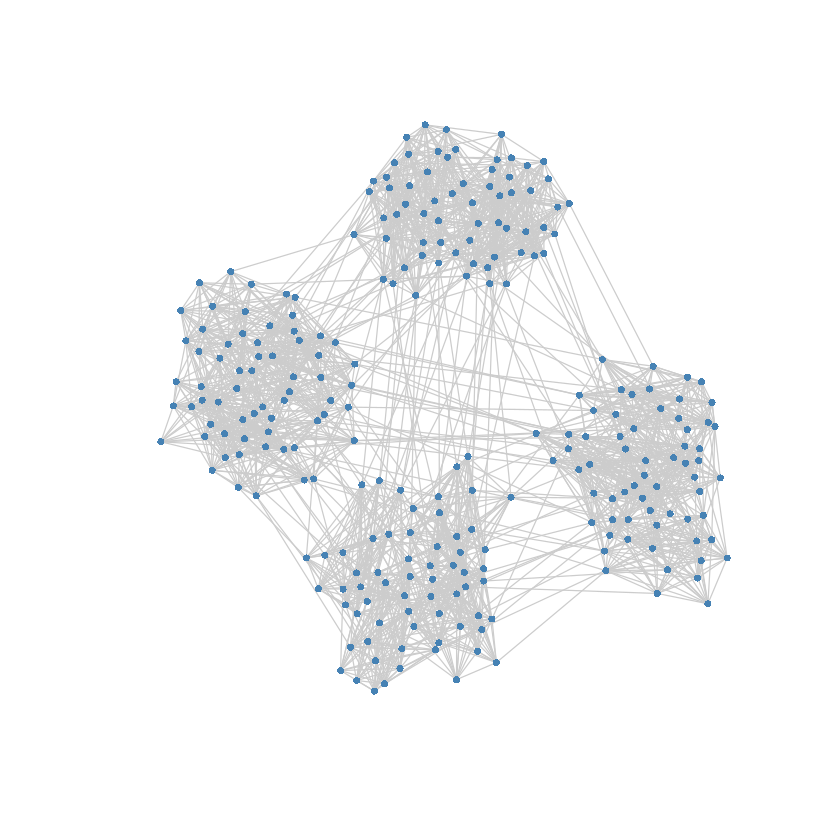

In [23]:
adj <- build_A(4, 13) 
diag(adj) <- 0 #no self-loop

g <- graph_from_adjacency_matrix(adj,mode = "undirected")

lay <- layout_with_fr(g)
plot(g, vertex.color="steelblue", vertex.label=NA, edge.color="gray80", vertex.size=2.5, vertex.frame.color=NA)

mean(degree(g))

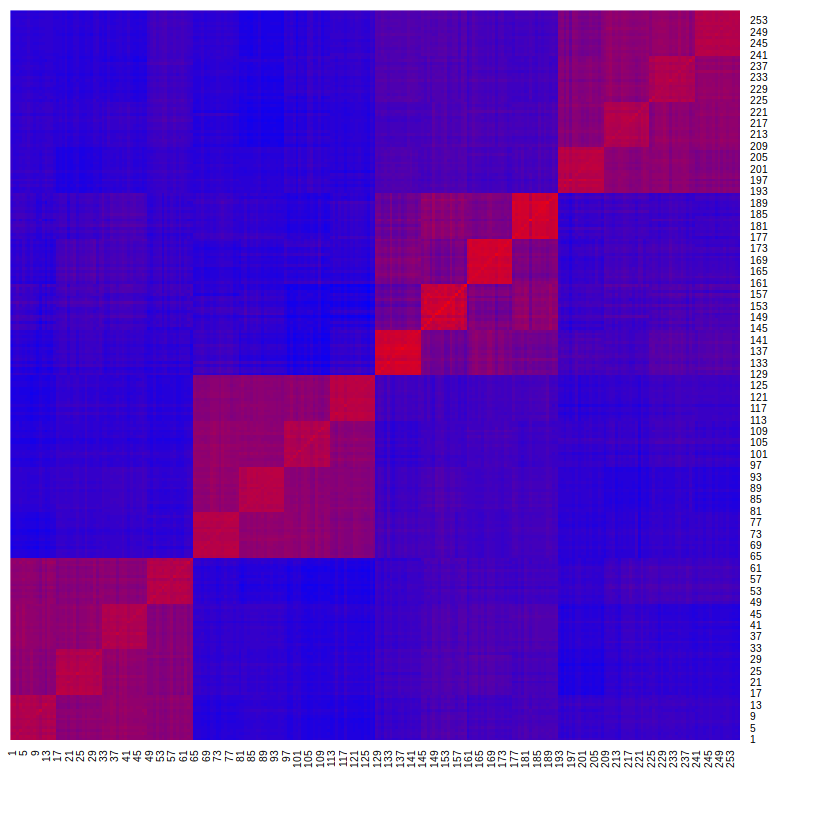

In [24]:
for(i in 1:num){
    p0 <- runif(N,-pi, pi)
    corr_mean <- corr_mean + kuramoto(steps=M, lambda=l, h=h_step, graph=g, phase=p0, natFreq=w0)
}
# normalized correlation matrix
corr_mean <- (corr_mean/num+1)/2

my_colors <- colorRampPalette(c("blue", "red"))(50)  
heatmap(corr_mean, Rowv=NA, Colv=NA, col = my_colors)

[1] 0.15878143 0.15705814 0.14323183 0.08664642 0.08117776

[1] 0.8122135 0.7588560 0.2285525 0.1950296 0.1917669

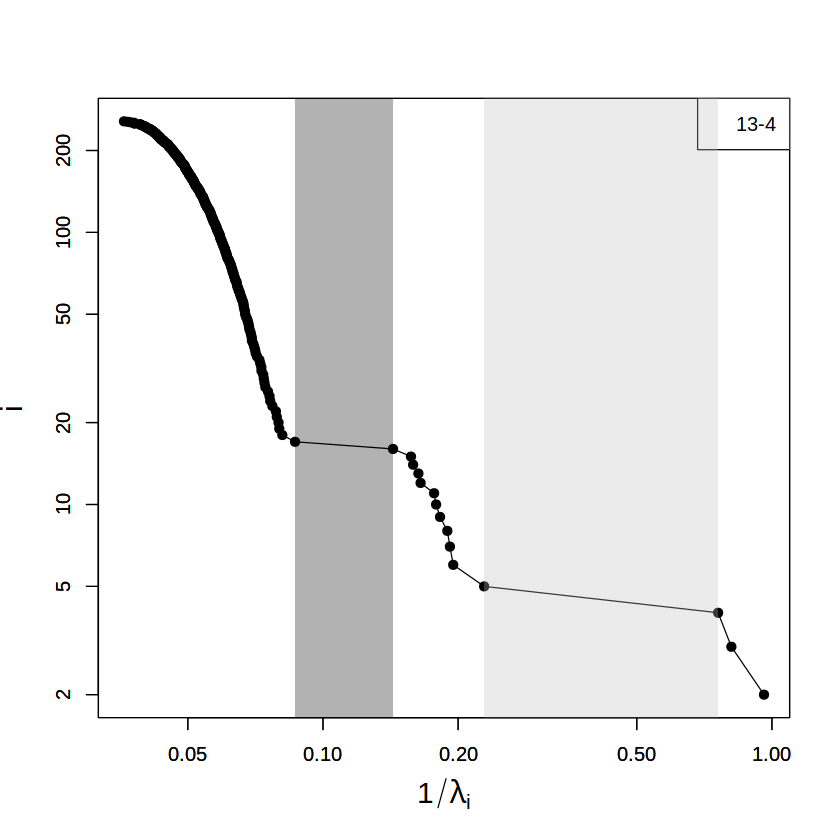

In [26]:
## Rank index i Vs 1/lambda_i

# Laplacian matric
L <- matrix(diag(rowSums(adj)),ncol=N) - adj
ev_L <- sort(eigen(L)$values)[2:N]
i <- 2:256
plot(1/ev_L, i, log='xy', type='l', xlab=TeX(r'($1/\lambda_i$)'), ylab=TeX(r'($i$)'), cex.lab=1.5)
par(new=T)
plot(1/ev_L, i, log='xy', pch=19, xlab='', ylab='')
legend('topright',legend='13-4')

# settings for the plot
1/ev_L[which(1/ev_L<=0.16)][1:5]
xlim2 <- 1/ev_L[which(1/ev_L<=0.16)[3]]
xlim1 <- 1/ev_L[which(1/ev_L<=0.16)[4]]

1/ev_L[which(1/ev_L<=0.9)][1:5]
xlim4 <- 1/ev_L[which(1/ev_L<=0.9)[2]]
xlim3 <- 1/ev_L[which(1/ev_L<=0.9)[3]]

rect(xleft = xlim1, xright = xlim2, ybottom = par("usr")[2], ytop = 350, 
  border = NA, col = adjustcolor("black", alpha = 0.3))
rect(xleft = xlim3, xright = xlim4, ybottom = par("usr")[2], ytop = 350, 
  border = NA, col = adjustcolor("grey", alpha = 0.3))

#### 15-2

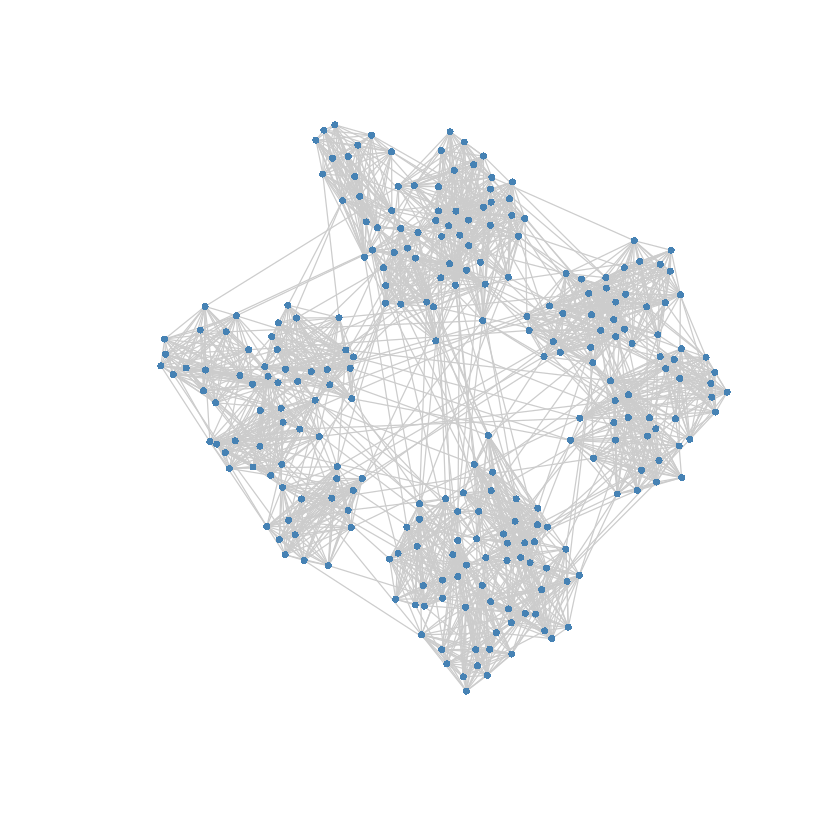

In [27]:
adj <- build_A(2, 15) 
diag(adj) <- 0 #no self-loop

g <- graph_from_adjacency_matrix(adj,mode = "undirected")

lay <- layout_with_fr(g)
plot(g, vertex.color="steelblue", vertex.label=NA, edge.color="gray80", vertex.size=2.5, vertex.frame.color=NA)

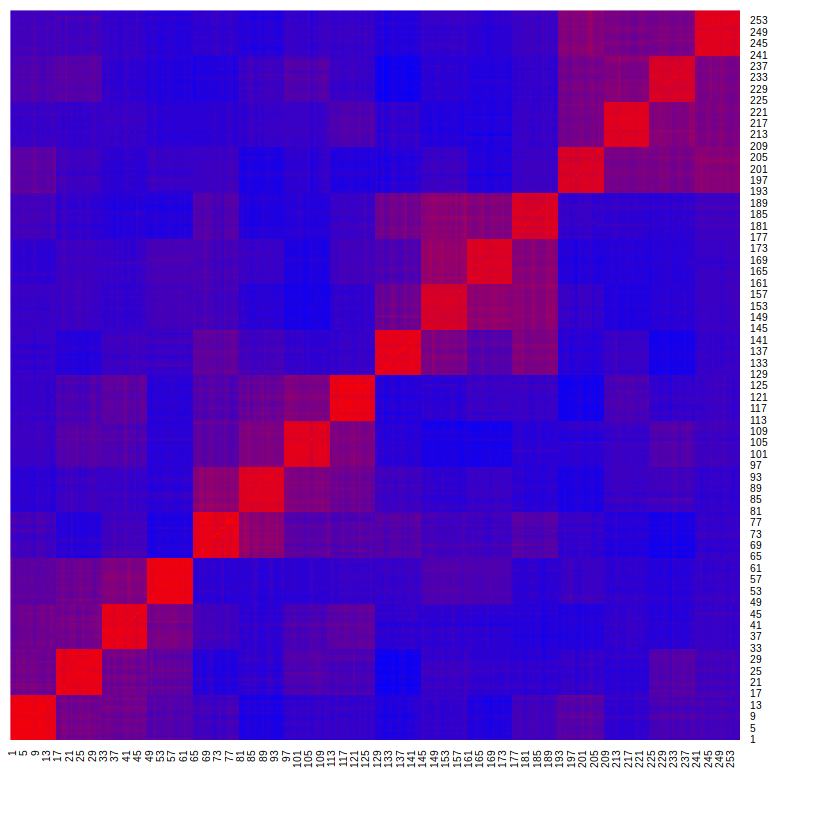

In [28]:
corr_mean <- matrix(0, nrow = N, ncol=N)
for(i in 1:num){
    p0 <- runif(N,-pi, pi)
    corr_mean <- corr_mean + kuramoto(steps=M, lambda=l, h=h_step, graph=g, phase=p0, natFreq=w0)
}
corr_mean <- (corr_mean/num+1)/2

my_colors <- colorRampPalette(c("blue", "red"))(50)  
heatmap(corr_mean, Rowv=NA, Colv=NA, col = my_colors)

[1] 0.2406806 0.2316676 0.2055756 0.0625000 0.0625000

[1] 0.8057735 0.7499560 0.4181891 0.3742105 0.3351459

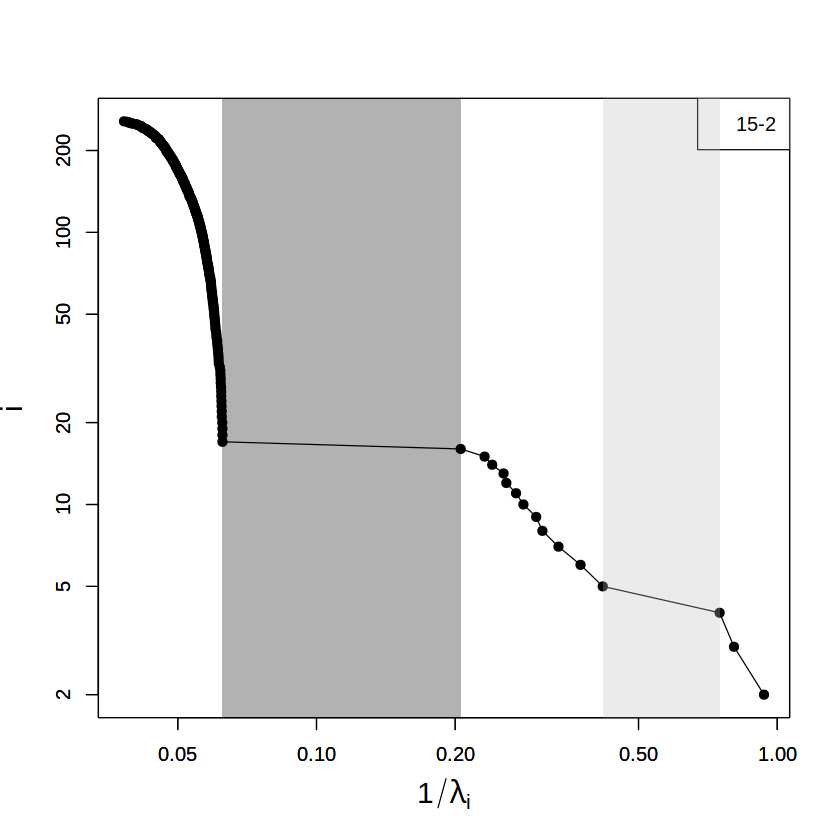

In [30]:
## Rank index i Vs 1/lambda_i

# Laplacian matric
L <- matrix(diag(rowSums(adj)),ncol=N) - adj
ev_L <- sort(eigen(L)$values)[2:N]
i <- 2:256
plot(1/ev_L, i, log='xy', type='l', xlab=TeX(r'($1/\lambda_i$)'), ylab=TeX(r'($i$)'), cex.lab=1.5)
par(new=T)
plot(1/ev_L, i, log='xy', pch=19, xlab='', ylab='')
legend('topright',legend='15-2')

# settings for the plot
T1 <- 0.25
1/ev_L[which(1/ev_L<=T1)][1:5]
xlim2 <- 1/ev_L[which(1/ev_L<=T1)[3]]
xlim1 <- 1/ev_L[which(1/ev_L<=T1)[4]]

T2 <- 0.9
1/ev_L[which(1/ev_L<=T2)][1:5]
xlim4 <- 1/ev_L[which(1/ev_L<=T2)[2]]
xlim3 <- 1/ev_L[which(1/ev_L<=T2)[3]]

rect(xleft = xlim1, xright = xlim2, ybottom = par("usr")[2], ytop = 350, 
  border = NA, col = adjustcolor("black", alpha = 0.3))
rect(xleft = xlim3, xright = xlim4, ybottom = par("usr")[2], ytop = 350, 
  border = NA, col = adjustcolor("grey", alpha = 0.3))